# IDENTIFICATION USING BOTH SURROGATE MODELS - COARSE AND FINE

In this notebook we leverage the pretrained surrogate models to identify fabrication uncertainties in MEMS accelerometers. We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [1]:
# Standard library imports
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model


#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 

sys.path.append('../../tests/Xaccelerometer_geometric/models')




Ray module not found. Multiprocessing features are not available


#### Decide sample to use for experimental data

In [2]:
sample = 100 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_"+str(sample)

#### Set Bayesian Identification Parameters

In [3]:
# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
CONFIGURATION_II = './config_II.json'

# Markov Chain Monte Carlo (MCMC) Configuration
MCMC_SETTINGS = {
    'parameter_start_points': [
        np.array([0.3, 0.0, 30.0]),
        np.array([0.4, 0.25, 30.0]),
        np.array([0.2, 0.25, 30.0]),
        np.array([0.4, -0.25, 30.0]),
        np.array([0.2, -0.25, 30.0])
    ],
    'bounds': ([0.1, -0.5, 29.0], [0.5, 0.5, 31.0]),
    'N': int(6e3),   # Total number of samples
    'Nb': int(1e3),  # Number of burn-in samples
    'Nt': 5,         # Number of chains
}

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-6 * 1000,
    'B': np.sqrt(200),
    'S': 5,
}

noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2


#### Load Surrogate Models

Load fine model 

In [4]:
# Data preprocessing for both configurations
data_processor_I = preprocessing(CONFIGURATION_I)
data_processor_II = preprocessing(CONFIGURATION_II)

# Load Fine model 
# Initialize and load models for both configurations
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])
# Define forward and gradient functions for the first configuration
fine_model = create_forward_model_function(data_processor_I, model_I)

Load coarse model 

In [5]:
# Import the function coarse_model
from coarse_model import *

num_samples = 640
num_parameters = 3
num_coarse_values = 75
# Define the neural network model
model_lowfidelity_NN = Sequential([
        Dense(150,input_shape=(num_parameters + num_coarse_values,),activation='linear')
       ])
# Load the model
model_lowfidelity_NN = load_model('./models/model_LF_NN_oo3.keras')
model_lf = create_model_LF_NN_oo3_opt()

load the data 

In [6]:
# Extract test data for visualization or further processing
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test

### Define Priors and Likelyhoods

 Define a custom Uniform random variable class

In [7]:
class CustomUniform:
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.area = np.prod(self.upper_bound - self.lower_bound)
    
    def pdf(self, x):
        if (self.lower_bound <= x).all() & (x <= self.upper_bound).all():
            return 1 / self.area
        else:
            return 0
        
    def logpdf(self, x):   
        if  self.pdf(x)==0:
            return -np.inf
        else:
            return np.log(self.pdf(x))
    
    def rvs(self):
        return np.random.uniform(self.lower_bound, self.upper_bound)



In [8]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0]) 

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
x_distribution = CustomUniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise * np.eye(len(data_processor_I.time))
y_distr_fine = tda.GaussianLogLike(y_observed, cov_likelihood) 

#points = np.linspace(0,0.0015-1e-5,150)
#phi = lambda t: np.abs(np.cos(2*np.pi*2500*t)) if t < 2.25/2500 and t > 0.25/2500 else 0
#coeff = [1+10*phi(t-1e-5*10) for t in points]
y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*10)

### Define a Posterior

In [9]:
# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse,model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, fine_model)

my_posteriors = [my_posterior_coarse, my_posterior_fine]



#### Perform least square optimization for each starting point

In [10]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

# Iterate over each parameter start point to perform optimization
for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points']):
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=fine_model, 
        start_point=start_point, 
        bounds=MCMC_SETTINGS['bounds']
    )

    # Append the optimized parameters to the list of initial guesses
    initial_guesses.append(optimized_params)

    # Print the optimized parameters for this iteration
    print(f"Optimized Params {index + 1}: {optimized_params}")


Real Params:  [ 0.189628  0.475492 29.631632]
Optimized Params 1: [ 0.18988675  0.47516785 29.66440894]
Optimized Params 2: [ 0.18990024  0.47522276 29.66125291]
Optimized Params 3: [ 0.18988237  0.47514022 29.6661897 ]
Optimized Params 4: [ 0.18989125  0.47517889 29.6639334 ]
Optimized Params 5: [ 0.18989352  0.4751682  29.66501468]


Set up the proposal

In [11]:
# Adaptive Metropolis
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= 0.1)
covariance_matrix
# get the maximum a posteriori point / 
#MAP = tda.get_MAP(my_posterior_fine)
#print(MAP)

array([[ 6.95461267e-06,  1.46053888e-05, -5.22697956e-04],
       [ 1.46053888e-05,  5.36828857e-05, -2.91751671e-03],
       [-5.22697956e-04, -2.91751671e-03,  1.83602643e-01]])

#### Do Metropolis Hastings Sampling

In [12]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []

# Iterate over each initial guess to set up and run the Markov chain sampler
for index, initial_guess in enumerate(initial_guesses[0:2]):
    samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=3200, n_chains=1,
                           initial_parameters=initial_guess, 
                           subsampling_rate = 3)
                           #adaptive_error_model='state-independent')
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(200, None, 3), groups="posterior")
    # Append the samples to the list
    samples_mh.append(idata)
    
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", az.ess(samples_mh[index]),"\n")

# Computing diagnostics and collecting results
print("Rhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')) ) 

# Save the numpy array to a file
np.save(OUTPUT_FILENAME, np.array([samples_mh[0].posterior['Overetch'].values[0], samples_mh[0].posterior['Offset'].values[0], samples_mh[0].posterior['Thickness'].values[0] ]) )  

Sampling chain 1/1


Running chain, α_c = 0.510, α_f = 0.11: 100%|██████████| 3200/3200 [00:07<00:00, 449.64it/s]
/Users/filippozacchei/anaconda3/envs/mems/lib/python3.9/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset>
Dimensions:    ()
Data variables:
    Overetch   float64 175.4
    Offset     float64 189.3
    Thickness  float64 191.9 

Sampling chain 1/1


Running chain, α_c = 0.533, α_f = 0.18: 100%|██████████| 3200/3200 [00:07<00:00, 455.94it/s]
/Users/filippozacchei/anaconda3/envs/mems/lib/python3.9/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(
/Users/filippozacchei/anaconda3/envs/mems/lib/python3.9/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset>
Dimensions:    ()
Data variables:
    Overetch   float64 234.4
    Offset     float64 242.5
    Thickness  float64 211.5 

Rhat:  <xarray.Dataset>
Dimensions:    ()
Data variables:
    Overetch   float64 1.001
    Offset     float64 1.003
    Thickness  float64 1.005


# Diagnostics 

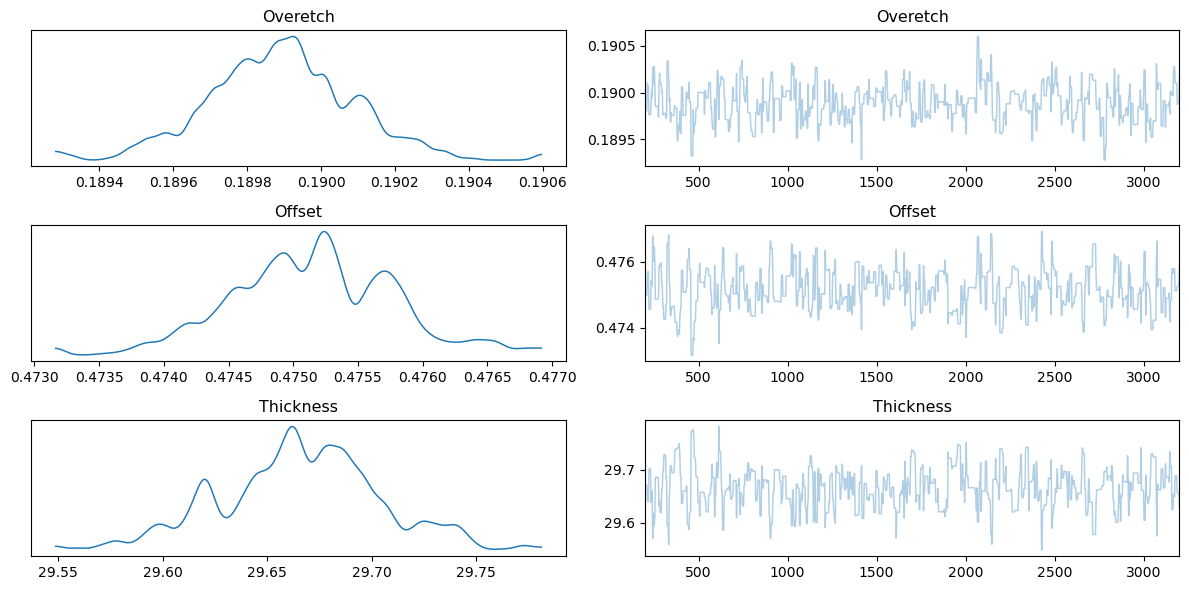

In [13]:
# Plot trace of the first set of samples
#idata = samples_mh[2].sel(draw=slice(MCMC_SETTINGS['Nb'], None,MCMC_SETTINGS['Nt']))
idata = samples_mh[0]
az.plot_trace(idata)
plt.tight_layout()
plt.show()


In [14]:
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ])
data.size

3003

Let's compare the prediction of the mean parameter combination and the experimental signal

In [15]:
def plot_results(time, y_true, y_obs, model, samplesMH, REAL_COLOR='red', LINE_WIDTH=1.5):
    plt.figure()
    plt.plot(1e3*time, y_true, c=REAL_COLOR, label='Real', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(np.mean(samplesMH, axis=1)), 'green', label='Pred', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, y_obs, '.-b', label='Noisy Signal', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(x_true), 'black', label = 'True parameters')
    plt.xlabel('Time [ms]')
    plt.ylabel(r'$\Delta C$ [fF]')
    plt.title(f'Overetch = {np.mean(samplesMH, axis=1)[0]:.4f}μm; Offset = {np.mean(samplesMH, axis=1)[1]:.4f}μm; Thickness = {np.mean(samplesMH, axis=1)[2]:.4f}μm', fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

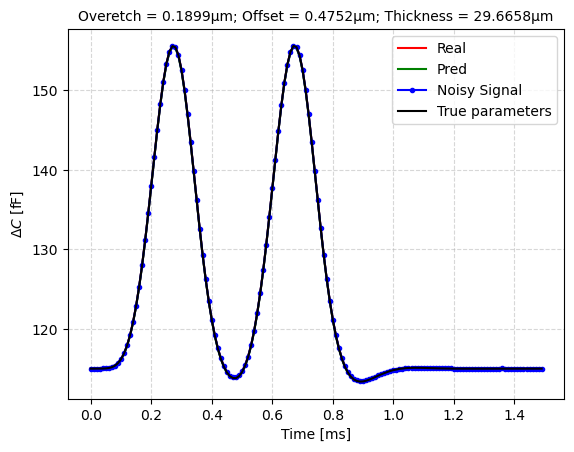

In [16]:
# Plotting and data collection
#data = az.convert_to_dataset
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ]) 
plot_results(data_processor_I.time, y_true, y_observed, model_lf, data)

Finally, let's look at the parameters distribution

In [40]:
def plot_parameter_distribution(parameter_samples1, parameter_samples2, x_true, parameter_name):
    plt.figure()
    kernel_density = gaussian_kde(parameter_samples1)
    x_range = np.linspace(np.min(parameter_samples1), np.max(parameter_samples1), 1000)
    plt.plot(x_range, kernel_density(x_range), color='blue', label='Density EA', linewidth=2)
    lower_bound, upper_bound = np.percentile(parameter_samples1, [2.5, 97.5])
    # plt.fill_between(x_range, 0, kernel_density(x_range), where=((x_range >= lower_bound) & (x_range <= upper_bound)), alpha=0.3, color='gray', label='95% C.I.')
    plt.xlabel(parameter_name)
    plt.ylabel('Density')
    plt.axvline(x_true, color='darkred', linestyle='dashed', linewidth=3, label='True')
    kernel_density = gaussian_kde(parameter_samples2)
    plt.plot(x_range, kernel_density(x_range), color='orange', label='Density DA', linewidth=2)
    lower_bound, upper_bound = np.percentile(parameter_samples2, [2.5, 97.5])
    plt.fill_between(x_range, 0, kernel_density(x_range), where=((x_range >= lower_bound) & (x_range <= upper_bound)), alpha=0.3, color='gray', label='95% C.I.')
   
    plt.legend()
    plt.show()

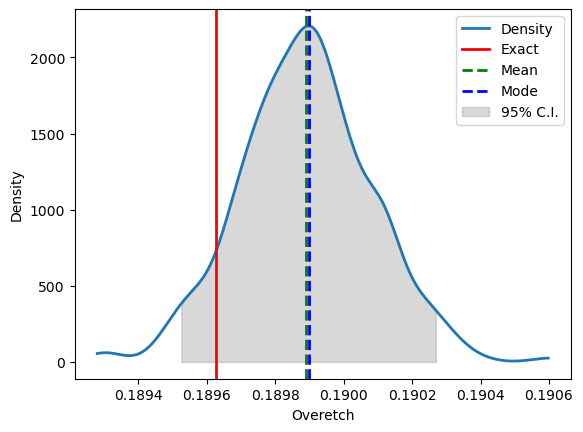

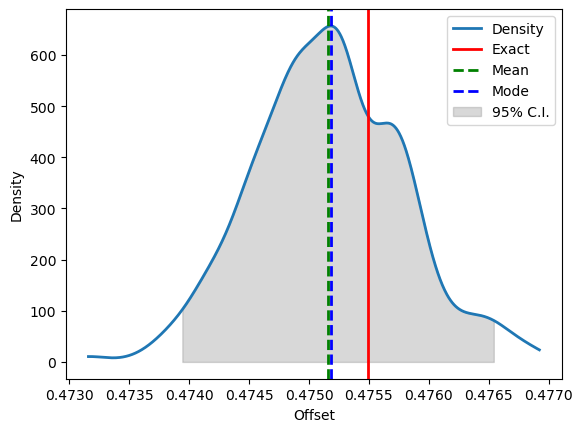

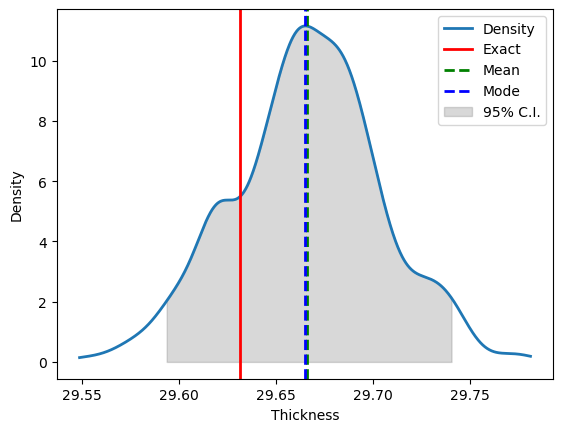

In [18]:
for j in range(3):
    plot_parameter_distribution(data[j,:], x_true[j], ['Overetch', 'Offset', 'Thickness'][j])

# Post Processing Plots

This section generates the plots in the paper.

In [31]:
from plotsPaper import *
samples1 = np.load(OUTPUT_FILENAME+'.npy')

OUTPUT_FILENAME2 = "./samples/sample_coarse_"+str(sample)

samples2 = np.load(OUTPUT_FILENAME2+'.npy')

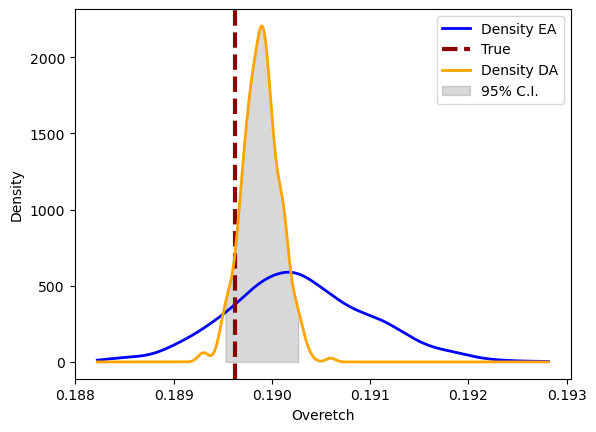

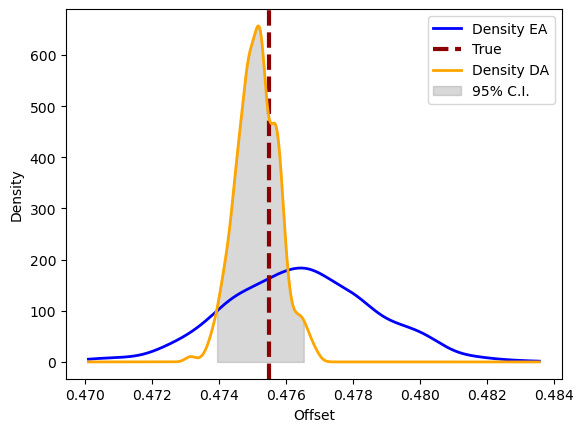

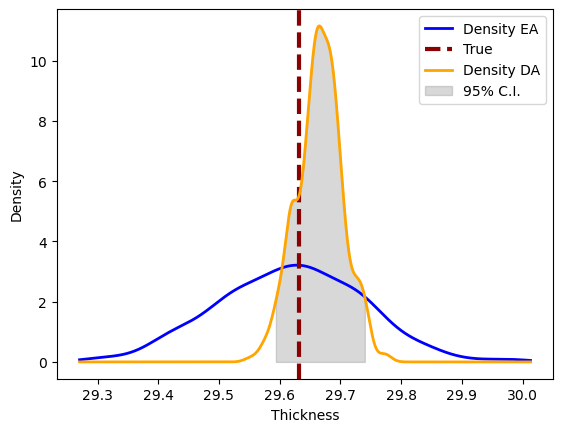

In [41]:
for j in range(3):
    plot_parameter_distribution(samples2[j,:],samples1[j,:], x_true[j], ['Overetch', 'Offset', 'Thickness'][j])

##### Histograms of the geometric parameters

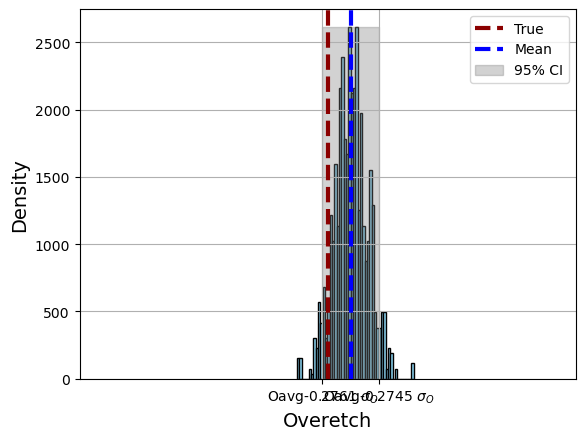

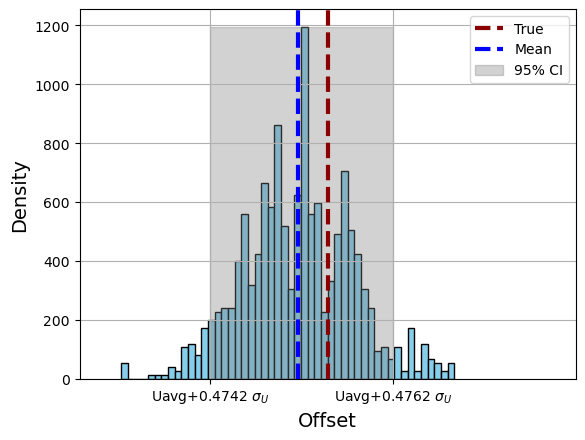

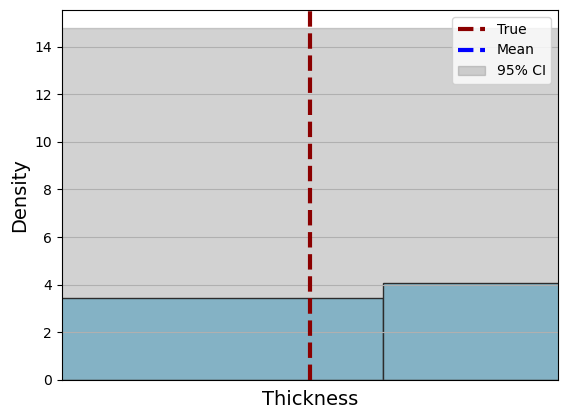

In [20]:
plot_histograms(samples, x_true)

ciao


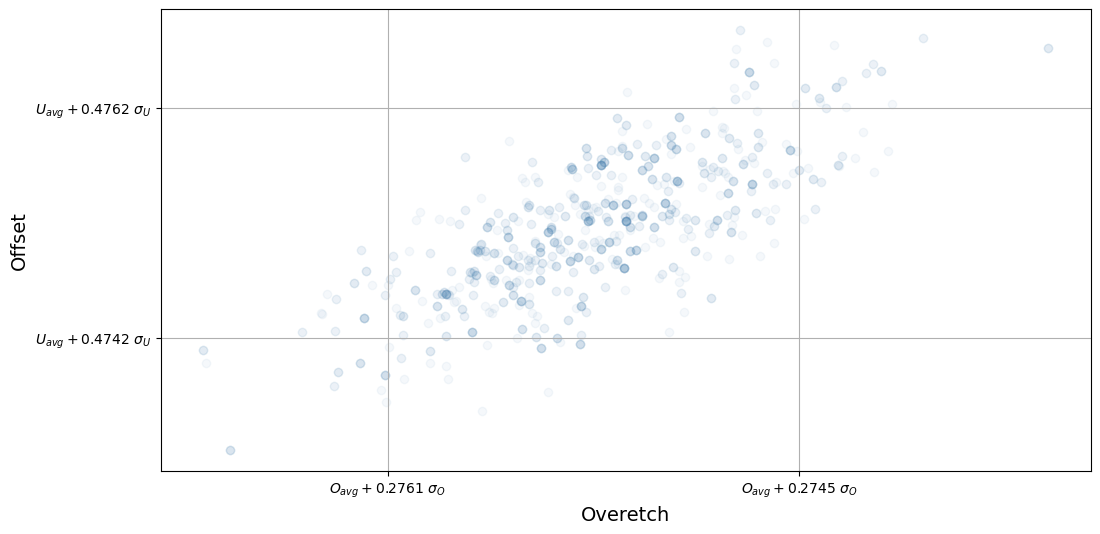

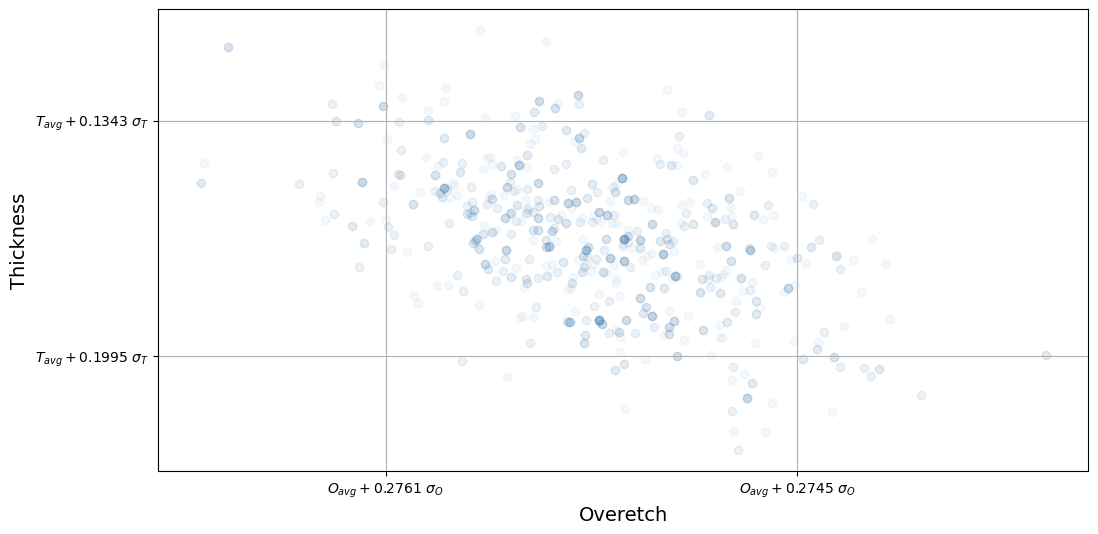

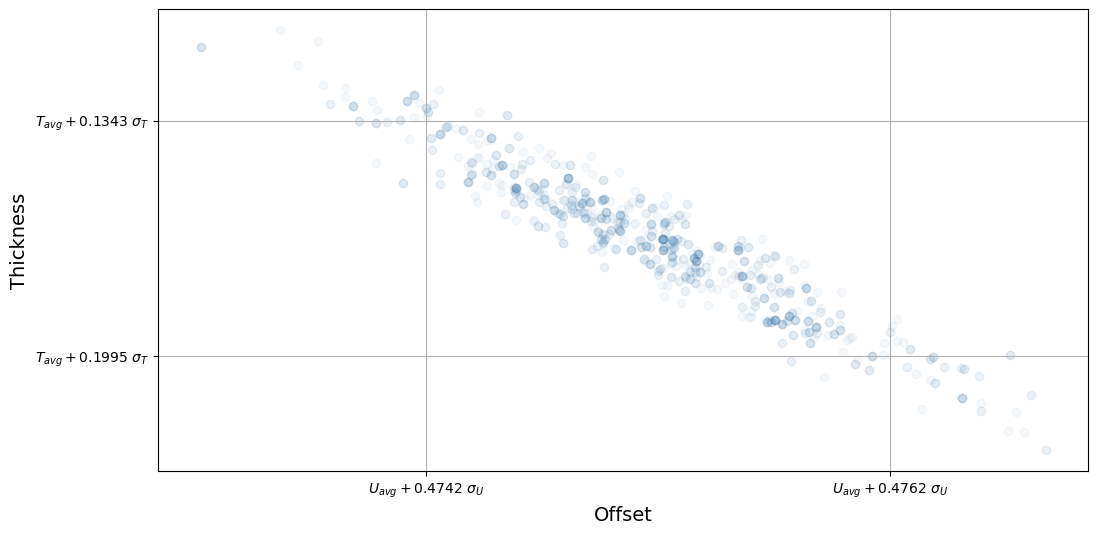

In [21]:
plot_scatter(samples)

AttributeError: 'AxesSubplot' object has no attribute 'xlim'

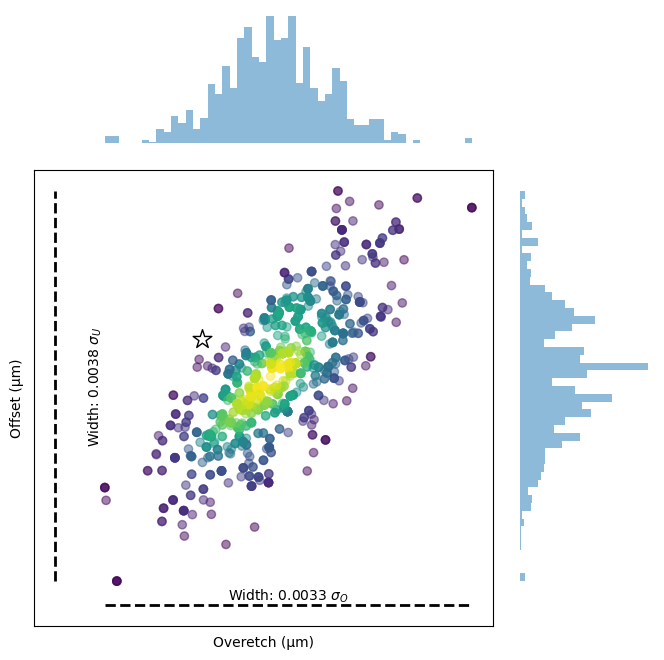

In [22]:
plot_density_scatter(samples, x_true, sigma_values=(0.2, 0.5))  # Adjust sigma values as needed

# EFFICIENCY COMPARISON 

In [ ]:
# Iterate over each initial guess to set up and run the Markov chain sampler
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=3200, n_chains=1,
                           initial_parameters=initial_guess, 
                           subsampling_rate = 3)
end_0 = timeit.default_timer() 


start_1 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posterior_fine, my_proposal, 
                         iterations=6000, n_chains=1,
                           initial_parameters=initial_guess)
end_1 = timeit.default_timer() 

print('Time MDA', (end_0-start_0))
print('Time only fine', (end_1 - start_1))
print('\nThe speedup coefficient is:', (end_1 - start_1)/(end_0-start_0))



Sampling chain 1/1


Running chain, α_c = 0.603, α_f = 0.33: 100%|██████████| 3200/3200 [00:07<00:00, 436.14it/s]


Sampling chain 1/1


Running chain, α_c = 0.593, α_f = 0.36: 100%|██████████| 3200/3200 [00:06<00:00, 473.33it/s]


Sampling chain 1/1


Running chain, α_c = 0.570, α_f = 0.28: 100%|██████████| 3200/3200 [00:06<00:00, 489.13it/s]


Sampling chain 1/1


Running chain, α_c = 0.633, α_f = 0.38: 100%|██████████| 3200/3200 [00:06<00:00, 501.30it/s]


Sampling chain 1/1


Running chain, α_c = 0.513, α_f = 0.24: 100%|██████████| 3200/3200 [00:06<00:00, 523.57it/s]


Sampling chain 1/1


Running chain, α = 0.33: 100%|██████████| 6000/6000 [00:10<00:00, 562.66it/s]


Sampling chain 1/1


Running chain, α = 0.33:  99%|█████████▉| 5967/6000 [00:10<00:00, 552.35it/s]

# Choose the optimal parameters 

In [ ]:
N_iter = 3200
N_subsampl = 3 
scale = 0.1 


MDA model 

In [ ]:
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= scale)

samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=N_iter, n_chains=1,
                           initial_parameters=initial_guess, 
                           subsampling_rate = N_subsampl)

idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])  
idata = idata.sel(draw=slice(200, None, 2), groups="posterior")
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", az.ess(idata),"\n")

Sampling chain 1/1


Running chain, α_c = 0.600, α_f = 0.28: 100%|██████████| 3200/3200 [00:06<00:00, 517.08it/s]
/Users/filippozacchei/anaconda3/envs/mems/lib/python3.9/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset>
Dimensions:    ()
Data variables:
    Overetch   float64 308.9
    Offset     float64 365.5
    Thickness  float64 350.1 



Only Fine model 

In [ ]:
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= scale)

samples = tda.sample(my_posterior_fine, my_proposal, 
                         iterations=6000, n_chains=1,
                           initial_parameters=initial_guess)

idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])  
idata = idata.sel(draw=slice(1000, None, 5), groups="posterior")
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", az.ess(idata),"\n")

Sampling chain 1/1


Running chain, α = 0.35: 100%|██████████| 6000/6000 [00:10<00:00, 561.60it/s]
/Users/filippozacchei/anaconda3/envs/mems/lib/python3.9/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset>
Dimensions:    ()
Data variables:
    Overetch   float64 414.4
    Offset     float64 390.6
    Thickness  float64 343.3 



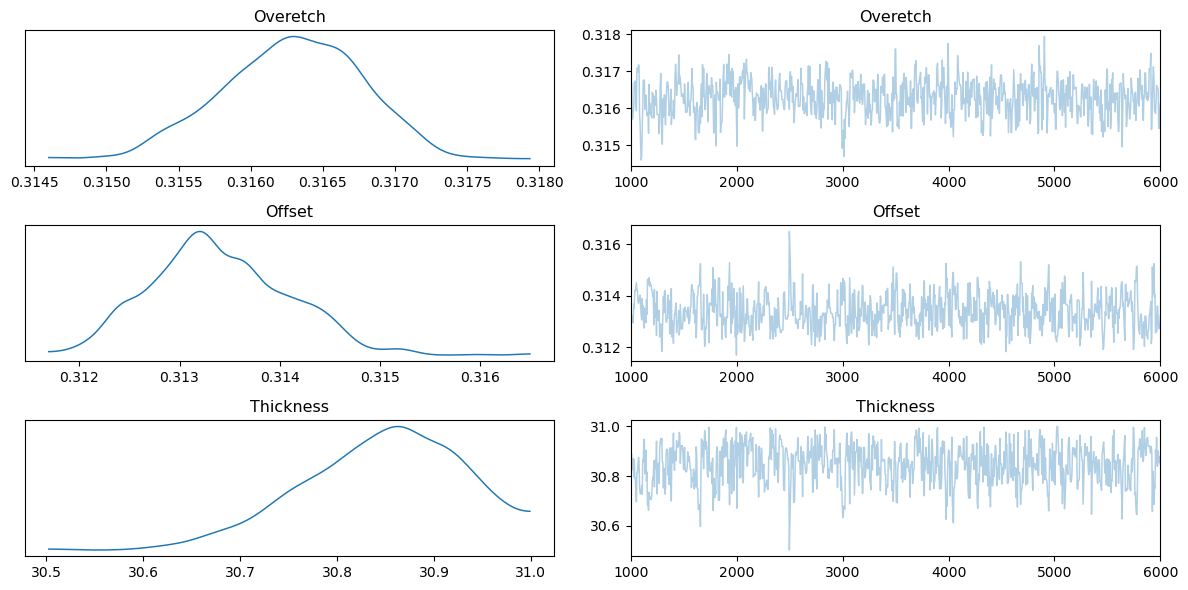

In [ ]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()